## imports

In [2]:
!pip install psynlig
!pip install umap-learn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from psynlig import pca_residual_variance
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## read data

In [3]:
df = pd.read_csv("../data/kddcup99.csv",index_col=0).reset_index(drop=True)
np.random.seed(42)
### change of decision variable classes by tagging 0 for normal and 1 for fraud ----just for kdd----
df.loc[(df.label !="normal"),"target"] = 1
df.loc[(df.label =="normal"),"target"] = 0
df = df.drop(['label'], axis=1)
feat_df = df.drop(['target'], axis=1)
label_df = df.target
df.describe()

,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
count,4.940200e+05,4.940200e+05,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,...,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000
mean,3.025616e+03,8.685308e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148245,0.010212,0.000111,...,188.666052,0.753781,0.030906,0.601936,0.006684,0.176754,0.176443,0.058118,0.057412,0.803091
std,9.882191e+05,3.304003e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355343,1.798328,0.010551,...,106.040205,0.410780,0.109259,0.481309,0.042133,0.380593,0.380920,0.230590,0.230141,0.397663
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,1.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##convert qualitative features to Binary and dimensionality reduction

senario 1 : all features were standardized

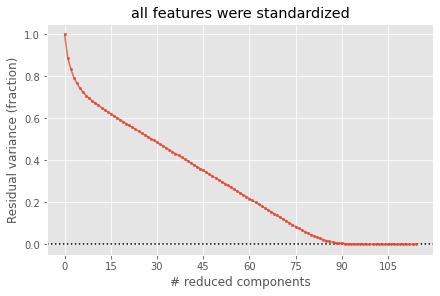

In [4]:
obj_df = feat_df.select_dtypes(include=['object']).copy()
categorical_df = pd.DataFrame()
for c in range(len(obj_df.columns)) :
    col = obj_df.columns[c]
    cat_df = pd.get_dummies(feat_df[col]).reset_index(drop=True) 
    cat_df = cat_df.iloc[:, :-1]
    categorical_df = pd.concat([categorical_df, cat_df], axis=1)    
features_df1 = feat_df.drop(obj_df.columns, axis=1)
features_df1 = pd.concat([features_df1, categorical_df], axis=1) 
col_name = features_df1.columns  
del categorical_df , obj_df
### normalze
features_df1 = pd.DataFrame(scale(features_df1))
features_df1.columns = col_name
### pca
plt.style.use('ggplot')
pca = PCA()
pca.fit_transform(features_df1)
pca_residual_variance(pca, marker='o', markersize=2, alpha=0.8)
plt.xlabel("# reduced components")
plt.title("all features were standardized")
plt.show()

senario 2 : binary features didnt standardize

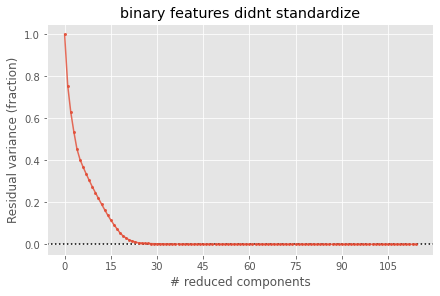

In [5]:
obj_df = feat_df.select_dtypes(include=['object']).copy()
categorical_df = pd.DataFrame()
for c in range(len(obj_df.columns)) :
    col = obj_df.columns[c]
    cat_df = pd.get_dummies(feat_df[col]).reset_index(drop=True) 
    cat_df = cat_df.iloc[:, :-1]
    categorical_df = pd.concat([categorical_df, cat_df], axis=1)    
features_df2 = feat_df.drop(obj_df.columns, axis=1)
### normalze
features_df2 = pd.DataFrame(scale(features_df2))
features_df2 = pd.concat([features_df2, categorical_df], axis=1) 
features_df2.columns = col_name  
del categorical_df , obj_df , col_name  
### pca
plt.style.use('ggplot')
pca = PCA()
pca.fit_transform(features_df2)
pca_residual_variance(pca, marker='o', markersize=2, alpha=0.8)
plt.xlabel("# reduced components")
plt.title("binary features didnt standardize")
plt.show()

## Balance check & Split data to 10 clusters

Balance check 

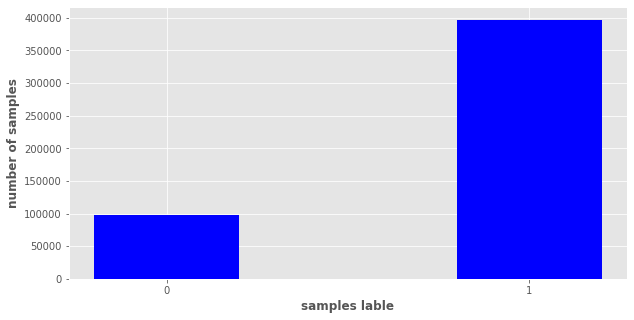

In [6]:
target = label_df.tolist()
target_counter = []
for i in range(2):
    counter = target.count(i)
    target_counter.append(counter)
fig = plt.figure(figsize = (10, 5))
numbers = ['0','1']
# creating the bar plot
plt.bar(numbers, target_counter, color ='blue', width = 0.4)
plt.xlabel("samples lable", fontweight ='bold')
plt.ylabel("number of samples", fontweight ='bold')
plt.show()

balancing of input data based on the number of normal and fraud samples

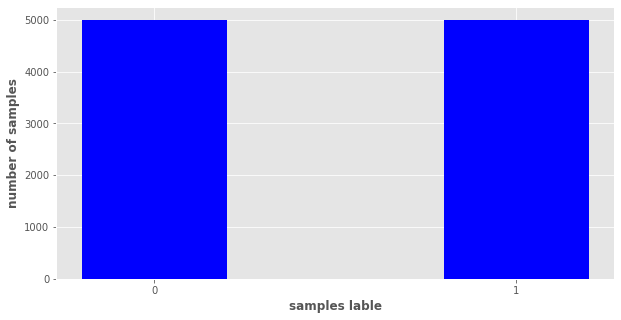

In [7]:
features_df1['target'] = target
df_normal_user = features_df1[features_df1.target == 0]
df_fraud_user = features_df1[features_df1.target == 1]    
#df_fraud_user_balanced = df_fraud_user.sample(n = len(df_normal_user))
df_normal_user = df_normal_user.sample(n = 5000)
df_fraud_user = df_fraud_user.sample(n = 5000)
features = pd.concat([df_normal_user, df_fraud_user], axis=0)    
features = features.sample(frac=1).reset_index(drop=True)

target = features.target.tolist()
target_counter = []
for i in range(2):
    counter = target.count(i)
    target_counter.append(counter)
fig = plt.figure(figsize = (10, 5))
numbers = ['0','1']
# creating the bar plot
plt.bar(numbers, target_counter, color ='blue', width = 0.4)
plt.xlabel("samples lable", fontweight ='bold')
plt.ylabel("number of samples", fontweight ='bold')
plt.show()

Split data to 10 clusters

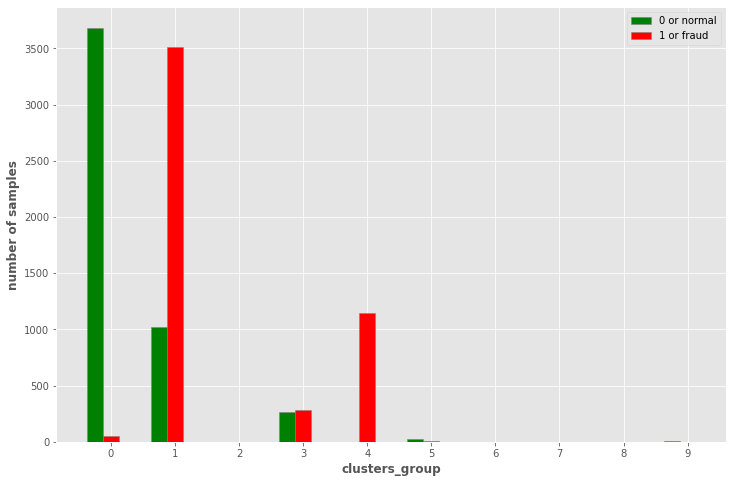

   normal  fraud 
0    3685      56
1    1024    3511
2       0       1
3     263     283
4       0    1145
5      21       4
6       2       0
7       1       0
8       1       0
9       3       0


In [8]:
data = np.array(features).reshape(-1, features.shape[1])
km = KMeans(n_clusters = 10,
            init = 'k-means++',             
            max_iter = 300,
            n_init = 10,                    
            random_state = 42)

features['cluster_group'] = km.fit_predict(data).tolist()
df_zero = []
df_one = []
nember_of_cluster = 10
for i in range(nember_of_cluster):
    df_1 = features[features['cluster_group']==i]
    df_1_list = df_1['target'].tolist()
    df_zero.append(df_1_list.count(0))
    df_one.append(df_1_list.count(1))

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(df_zero))
br2 = [x + barWidth for x in br1]
# Make the plot
plt.bar(br1, df_zero, color ='g', width = barWidth,
        edgecolor ='grey', label ='0 or normal')
plt.bar(br2, df_one, color ='r', width = barWidth,
        edgecolor ='grey', label ='1 or fraud')
lst = [i for i in range(0,10)] 
plt.xlabel('clusters_group', fontweight ='bold')
plt.ylabel('number of samples', fontweight ='bold')
plt.xticks([r + barWidth for r in range(len(df_zero))],lst) 
plt.legend()
plt.show()
print(pd.DataFrame({'normal' : df_zero, 'fraud ' : df_one}))

## unsupervised anomaly detection

In [9]:
x = features.drop(['cluster_group', 'target'], axis=1)
y = features.target
from sklearn import svm
from sklearn.metrics import recall_score, precision_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

One-Class Support Vector Machines without dimensionality reduction

In [10]:
np.random.seed(31)
svm_model = svm.OneClassSVM()
svm_model.fit(x)
svm_pred = svm_model.predict(x)
svm_pred = pd.Series(svm_pred).replace([-1,1],[1,0])
svm_conf_mat = pd.DataFrame(confusion_matrix(y, svm_pred))
print('*********confusion_matrix*********')
print(svm_conf_mat)
index = []
test_score = []
valid_score = []   
index.append("recall_score")
test_score.append(recall_score(y, svm_pred)) 
index.append("precision_score")
test_score.append(precision_score(y, svm_pred))
index.append("f1_score")
test_score.append(f1_score(y, svm_pred))  
index.append("cohen_kappa_score")
test_score.append(cohen_kappa_score(y, svm_pred))
index.append("roc_auccuracy_score")
test_score.append(roc_auc_score(y, svm_pred))
### summary scores in dataframe 
print('*********scores *********')
print(pd.DataFrame({"index":index ,"score" :test_score }))

*********confusion_matrix*********
      0     1
0  2394  2606
1  3079  1921
*********scores *********
                 index     score
0         recall_score  0.384200
1      precision_score  0.424343
2             f1_score  0.403275
3    cohen_kappa_score -0.137000
4  roc_auccuracy_score  0.431500


One-Class Support Vector Machines with PCA

In [11]:
np.random.seed(31)
pca = PCA(n_components=4)     
pca.fit(x)  
pca_data = pca.fit_transform(x)

svm_model = svm.OneClassSVM()
svm_model.fit(pca_data)
svm_pred_pca = svm_model.predict(pca_data)
svm_pred_pca = pd.Series(svm_pred_pca).replace([-1,1],[1,0])
svm_conf_mat = pd.DataFrame(confusion_matrix(y, svm_pred_pca))
print('*********confusion_matrix*********')
print(svm_conf_mat)
index = []
test_score = []
valid_score = []   
index.append("recall_score")
test_score.append(recall_score(y, svm_pred_pca)) 
index.append("precision_score")
test_score.append(precision_score(y, svm_pred_pca))
index.append("f1_score")
test_score.append(f1_score(y, svm_pred_pca))  
index.append("cohen_kappa_score")
test_score.append(cohen_kappa_score(y, svm_pred_pca))
index.append("roc_auccuracy_score")
test_score.append(roc_auc_score(y, svm_pred_pca))
### summary scores in dataframe 
print('*********scores *********')
print(pd.DataFrame({"index":index ,"score" :test_score }))

*********confusion_matrix*********
      0     1
0  3149  1851
1   759  4241
*********scores *********
                 index     score
0         recall_score  0.848200
1      precision_score  0.696159
2             f1_score  0.764695
3    cohen_kappa_score  0.478000
4  roc_auccuracy_score  0.739000


One-Class Support Vector Machines with t-SNE

In [12]:
np.random.seed(31)
model = TSNE(n_components=3, random_state=41, perplexity=100,  n_iter=1000 ) 
tsne_data = model.fit_transform(x) 

svm_model = svm.OneClassSVM()
svm_model.fit(tsne_data)
svm_pred_tsne = svm_model.predict(tsne_data)
svm_pred_tsne = pd.Series(svm_pred_tsne).replace([-1,1],[1,0])
svm_conf_mat = pd.DataFrame(confusion_matrix(y, svm_pred_tsne))
print('*********confusion_matrix*********')
print(svm_conf_mat)
index = []
test_score = []
valid_score = []   
index.append("recall_score")
test_score.append(recall_score(y, svm_pred_tsne)) 
index.append("precision_score")
test_score.append(precision_score(y, svm_pred_tsne))
index.append("f1_score")
test_score.append(f1_score(y, svm_pred_tsne))  
index.append("cohen_kappa_score")
test_score.append(cohen_kappa_score(y, svm_pred_tsne))
index.append("roc_auccuracy_score")
test_score.append(roc_auc_score(y, svm_pred_tsne))
### summary scores in dataframe 
print('*********scores *********')
print(pd.DataFrame({"index":index ,"score" :test_score }))



*********confusion_matrix*********
      0     1
0  2645  2355
1  1636  3364
*********scores *********
                 index     score
0         recall_score  0.672800
1      precision_score  0.588215
2             f1_score  0.627670
3    cohen_kappa_score  0.201800
4  roc_auccuracy_score  0.600900


One-Class Support Vector Machines with umap

In [13]:
np.random.seed(31)
model = umap.UMAP(n_neighbors=200, n_components=6)
umap_data = model.fit_transform(x)
svm_model = svm.OneClassSVM()
svm_model.fit(umap_data)
svm_pred_umap = svm_model.predict(umap_data)
svm_pred_umap = pd.Series(svm_pred_umap).replace([-1,1],[1,0])
svm_conf_mat = pd.DataFrame(confusion_matrix(y, svm_pred_umap))
print('*********confusion_matrix*********')
print(svm_conf_mat)
index = []
test_score = []
valid_score = []   
index.append("recall_score")
test_score.append(recall_score(y, svm_pred_umap)) 
index.append("precision_score")
test_score.append(precision_score(y, svm_pred_umap))
index.append("f1_score")
test_score.append(f1_score(y, svm_pred_umap))  
index.append("cohen_kappa_score")
test_score.append(cohen_kappa_score(y, svm_pred_umap))
index.append("roc_auccuracy_score")
test_score.append(roc_auc_score(y, svm_pred_umap))
### summary scores in dataframe 
print('*********scores *********')
print(pd.DataFrame({"index":index ,"score" :test_score }))

*********confusion_matrix*********
      0     1
0  3370  1630
1  1630  3370
*********scores *********
                 index  score
0         recall_score  0.674
1      precision_score  0.674
2             f1_score  0.674
3    cohen_kappa_score  0.348
4  roc_auccuracy_score  0.674


error analusis for svm model outputs

In [14]:
features['pred_label'] = svm_pred_pca 
error_df = features[features.target != features.pred_label]

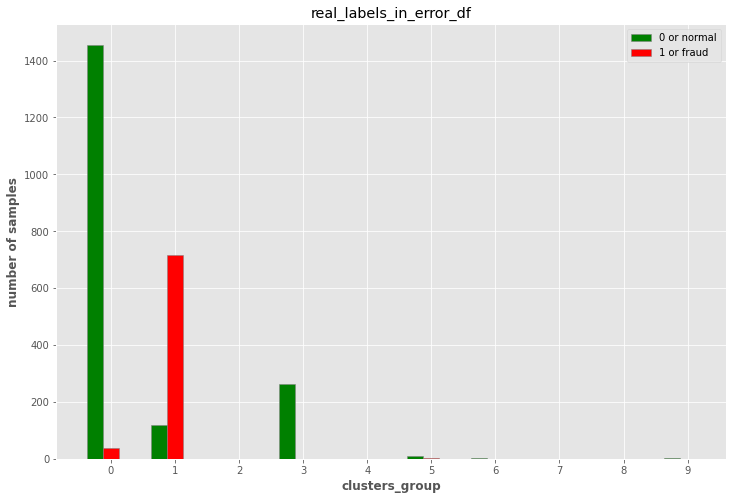

   normal  fraud 
0    1456      38
1     118     716
2       0       0
3     262       0
4       0       1
5      10       4
6       2       0
7       0       0
8       1       0
9       2       0


In [15]:
df_zero = []
df_one = []
nember_of_cluster = 10
for i in range(nember_of_cluster):
    df_1 = error_df[error_df['cluster_group']==i]
    df_1_list = df_1['target'].tolist()
    df_zero.append(df_1_list.count(0))
    df_one.append(df_1_list.count(1))

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(df_zero))
br2 = [x + barWidth for x in br1]
# Make the plot
plt.bar(br1, df_zero, color ='g', width = barWidth,
        edgecolor ='grey', label ='0 or normal')
plt.bar(br2, df_one, color ='r', width = barWidth,
        edgecolor ='grey', label ='1 or fraud')
lst = [i for i in range(0,10)] 
plt.xlabel('clusters_group', fontweight ='bold')
plt.ylabel('number of samples', fontweight ='bold')
plt.xticks([r + barWidth for r in range(len(df_zero))],lst) 
plt.legend()
plt.title('real_labels_in_error_df')
plt.show()
print(pd.DataFrame({'normal' : df_zero, 'fraud ' : df_one}))

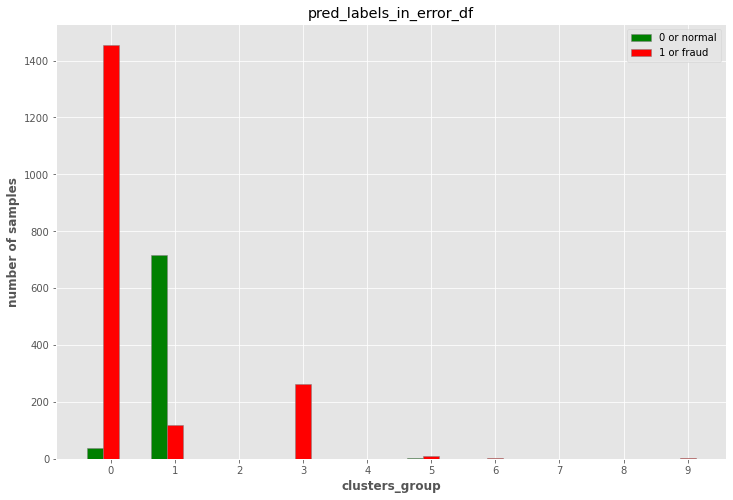

   normal  fraud 
0      38    1456
1     716     118
2       0       0
3       0     262
4       1       0
5       4      10
6       0       2
7       0       0
8       0       1
9       0       2


In [16]:
df_zero = []
df_one = []
nember_of_cluster = 10
for i in range(nember_of_cluster):
    df_1 = error_df[error_df['cluster_group']==i]
    df_1_list = df_1['pred_label'].tolist()
    df_zero.append(df_1_list.count(0))
    df_one.append(df_1_list.count(1))

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(df_zero))
br2 = [x + barWidth for x in br1]
# Make the plot
plt.bar(br1, df_zero, color ='g', width = barWidth,
        edgecolor ='grey', label ='0 or normal')
plt.bar(br2, df_one, color ='r', width = barWidth,
        edgecolor ='grey', label ='1 or fraud')
lst = [i for i in range(0,10)] 
plt.xlabel('clusters_group', fontweight ='bold')
plt.ylabel('number of samples', fontweight ='bold')
plt.xticks([r + barWidth for r in range(len(df_zero))],lst) 
plt.legend()
plt.title('pred_labels_in_error_df')
plt.show()
print(pd.DataFrame({'normal' : df_zero, 'fraud ' : df_one}))